### Notebook to visualize FreeSurfer measaures on surfaces and parcellations

In [1]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from nibabel.freesurfer.mghformat import load
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import datasets, surface, plotting
import seaborn as sns

In [13]:
### Load data
current_release = "Oct_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"
dataset = "qpn"


dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# imaging derivatives
FS_dir = f"{dataset_dir}/derivatives/freesurfer/v{FS_version}"
surf_dir = f"{FS_dir}/surfmaps/{session}/"

# ROI stats

DKT_csv = "/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs/CT_DKT_df.csv"


# Surface maps
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"

### Get analysis groups

In [16]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

Control: 69
PD: 194


participant_id        redcap_event_name  \
0        MNI0028  Baseline (Arm 1: C-OPN)   
1        MNI0056  Baseline (Arm 1: C-OPN)   
2        MNI0058  Baseline (Arm 1: C-OPN)   
3        MNI0068  Baseline (Arm 1: C-OPN)   
4        MNI0079  Baseline (Arm 1: C-OPN)   

                              Hoehn and Yahr Stage:   \
0  (2) Bilateral involvement without impairment o...   
1  (3) Bilateral disease: mild to moderate disabi...   
2  (1) Unilateral involvement only, usually with ...   
3                                                NaN   
4  (2) Bilateral involvement without impairment o...   

  Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant  \
0                                 Unsure / Incertain                                                                  
1                                          Yes / Oui                                                                  
2                                          Yes / Oui                                                                  
3                                                NaN                                                                  
4                                          Yes / Oui                                                                  

                Final impression / Impression finale  \
0                              Uncertain / Incertain   
1  Meets exclusion criteria / Rencontre des critè...   
2                              Uncertain / Incertain   
3                                                NaN   
4  Meets criteria for Parkinson's disease / Répon...   

   Determined diagnosis:  If score = 0, Parkinson's Disease (PD)  If score = 1, Progressive Supranuclear Palsy (PSP)  If score = 2, Multiple System Atrophy (MSA)  If score = 3, Corticobasal Syndrome (CBS)  If score = 4, Dementia with Lewy Bodies (DLB)  If score = 5, Frontotemporal Dementia (FTD)  If score = 6, Essential Tremor (ET)  If score = 7, REM Sleep Behaviour Disorder (RBD)  \
0                                                NaN                                                                                                                                                                                                                                                                                                                                              
1                                                0.0                                                                                                                                                                                                                                                                                                                                              
2                                                0.0                                                                                                                                                                                                                                                                                                                                              
3                                                0.0                                                                                                                                                                                                                                                                                                                                              
4                                                0.0                                                                                                                                                                                                                                                                                                                                              

  diagnosis_group_f

### Plot CT on surface
- e.g. lh_surf_concat_thickness_10mm.mgh

In [17]:
def read_FS_surf(FS_surf_dir,participant_id, meas="thickness", fwhm=10):
    """ Read freesurfer surfaces for a given participant and hemisphere """
    # sub-MNI0143_lh_surf_thickness_10mm.mgh

    surf_data = {}
    try:
        for hemi in ["lh", "rh"]:
            surf_file = f"{FS_surf_dir}/{participant_id}_{hemi}_surf_{meas}_{fwhm}mm.mgh"
            surf_data[hemi] = nib.load(surf_file).get_fdata()

        return surf_data
    
    except:
        print(f"Error reading {participant_id}")
        return None    
    


In [4]:
PD_surf_data_lh = []
PD_surf_data_rh = []
control_surf_data_lh = []
control_surf_data_rh = []

for participant_id in control_participants:
    surf_data = read_FS_surf(FS_surf_dir,participant_id)
    control_surf_data_lh.append(surf_data["lh"]) 
    control_surf_data_rh.append(surf_data["rh"]) 

for participant_id in PD_participants:
    surf_data = read_FS_surf(FS_surf_dir, participant_id)
    PD_surf_data_lh.append(surf_data["lh"])
    PD_surf_data_rh.append(surf_data["rh"])

control_surf_lh_avg = np.squeeze(np.mean(control_surf_data_lh, axis=0))
control_surf_rh_avg = np.squeeze(np.mean(control_surf_data_rh, axis=0))

PD_surf_lh_avg = np.squeeze(np.mean(PD_surf_data_lh, axis=0))
PD_surf_rh_avg = np.squeeze(np.mean(PD_surf_data_rh, axis=0))

print(f"control_surf_lh_min: {np.min(control_surf_lh_avg)}")
print(f"control_surf_rh_min: {np.min(control_surf_rh_avg)}")

print(f"PD_surf_lh_min: {np.min(PD_surf_lh_avg)}")
print(f"PD_surf_rh_min: {np.min(PD_surf_rh_avg)}")


In [ ]:
sns.histplot(control_surf_lh_avg.flatten(), color="blue", alpha=0.5)
sns.histplot(PD_surf_lh_avg.flatten(), color="red", alpha=0.5)
sns.histplot(control_surf_rh_avg.flatten(), color="blue", alpha=0.5)
sns.histplot(PD_surf_rh_avg.flatten(), color="red", alpha=0.5)


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

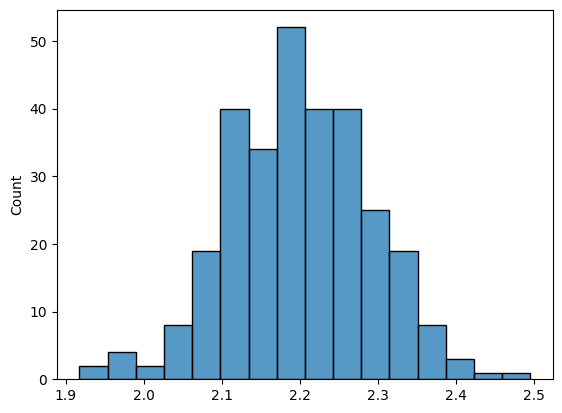

In [10]:
sns.histplot(CT_data_subject_avg, kde=False)

In [84]:
DX_groups = ["CTRL","PD"] 
hemi_list = ["lh", "rh"]
fwhm = 10

surf_dict = {}
for grp in DX_groups:
    hemi_CT_list = []
    for j, hemi in enumerate(hemi_list):
        CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{grp}_{fwhm}mm.mgh")
        avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))
        hemi_CT_list.append(np.expand_dims(avg_CT,1))
    
    surf_dict[grp] = np.squeeze(np.concatenate(hemi_CT_list, axis=0))


### Controls

In [21]:
# Plot the surfaces
CTRL_surf = surf_dict["CTRL"]
plot_hemispheres( pial_lh, pial_rh, array_name=CTRL_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(255, 255, 255, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)


NameError: name 'surf_dict' is not defined

### Parkinsons

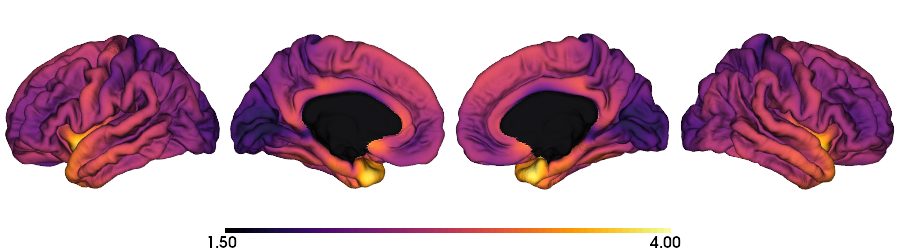

In [86]:
PD_surf = surf_dict["PD"]
plot_hemispheres( pial_lh, pial_rh, array_name=PD_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)

### Difference between CTRL and PD

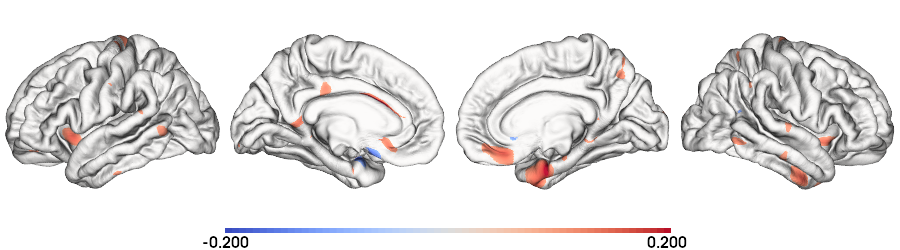

In [87]:
plot_thresh = 0.1
diff_surf = surf_dict["CTRL"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

plot_hemispheres( pial_lh, pial_rh, array_name=diff_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap="coolwarm", transparent_bg=True)

### Plot labels on the surface

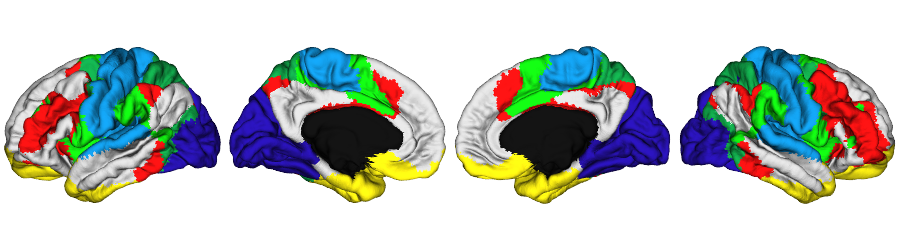

In [88]:
# plot labels on surface
plot_hemispheres(pial_lh, pial_rh, array_name=labels, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='nipy_spectral', transparent_bg=True)

### Plot average CT per parcel

In [9]:
def get_mean_CT_per_parcel(labels, CT_vals, round_decimals=1):

    CT_parcel_df = pd.DataFrame()
    CT_parcel_df["CT"] = CT_vals
    CT_parcel_df["label"] = labels
    mean_CT_per_label_df = CT_parcel_df.groupby("label").mean().reset_index()
    label_CT_map_dict = dict(zip(mean_CT_per_label_df["label"], mean_CT_per_label_df["CT"]))
    CT_parcel_df["CT_parcel"] = CT_parcel_df["label"].replace(label_CT_map_dict)
    mean_CT_parcel = np.array(CT_parcel_df["CT_parcel"],dtype=np.float32).round(round_decimals)

    return mean_CT_parcel

### Controls

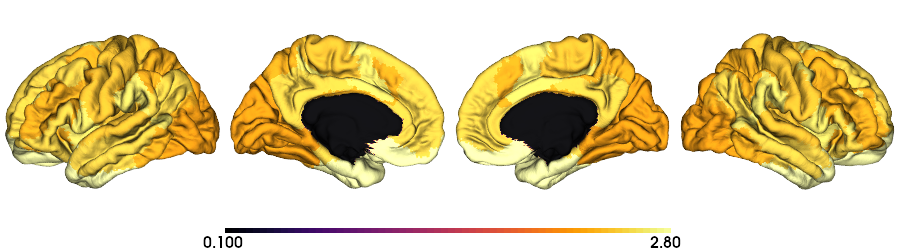

In [90]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, CTRL_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True,color_bar='bottom') #color_range=(1.5, 4)

### PD

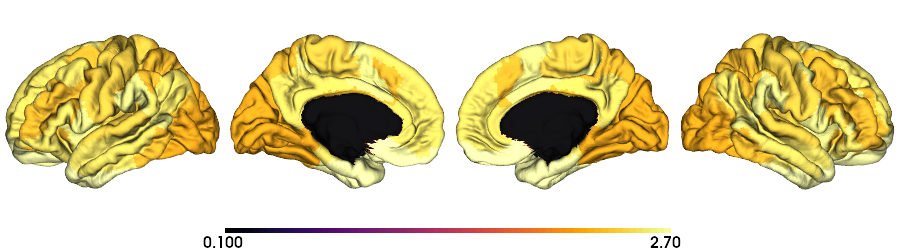

In [91]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, PD_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom') #color_range=(1.5, 4),

### Difference between CTRL and PD

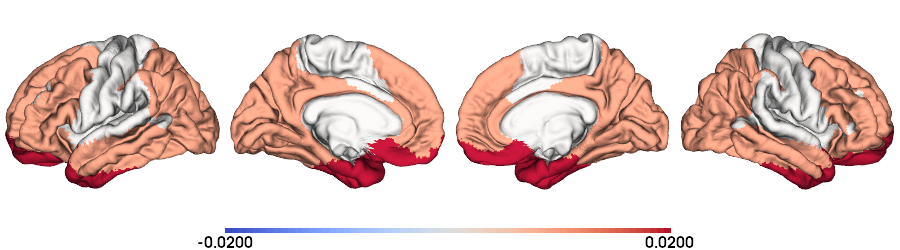

In [92]:
# plot mean CT per parcel on surface
plot_thresh = 0.05
diff_surf = surf_dict["CTRL"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

plot_array = get_mean_CT_per_parcel(labels, diff_surf, round_decimals=2)
color_range = (-max(abs(plot_array)), max(abs(plot_array)))
cmap = "coolwarm"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom',color_range=color_range)

# Attempts to plot DKT parcels from aparc summaries...

### Surface and annotation files

- Possible surfaces: ["fsaverage", "fsaverage5"]
- Possible annot: 
    - "fsaverage": ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]
    - "fsaverage5": ["schaefer-500"]

In [5]:
template_surface = "fsaverage" # "fsaverage" or "fsaverage5"
annot = "aparc" #"Yeo2011_7Networks_N1000"

if template_surface == "fsaverage":
    fsaverage_dir = f"{FS_dir}/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')


if annot in ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]:
    annot_lh= f"{annot_dir}/lh.{annot}.annot"
    annot_rh= f"{annot_dir}/rh.{annot}.annot"
else:
    annot_lh= f"{annot_dir}/lh.{annot}_mics.annot"
    annot_rh= f"{annot_dir}/rh.{annot}_mics.annot"

labels = np.concatenate((nib.freesurfer.read_annot(annot_lh)[0], nib.freesurfer.read_annot(annot_rh)[0]), axis=0)

print(f"tempate surface: {template_surface}, annot: {annot}")
print(f"shape of concat array: {labels.shape}")

tempate surface: fsaverage, annot: aparc
shape of concat array: (327684,)


### Compare fsaverage and subject space labels

In [24]:
def get_label_info(annot_file):
    annot = nib.freesurfer.read_annot(annot_file)
    labels = annot[0]
    n_vertices = len(labels)
    label_idx = np.unique(labels)
    label_names = annot[2]
    
    return n_vertices, label_idx, label_names

In [44]:
fsaverage_label_dir = f"{FS_dir}/output/ses-01/fsaverage/label/"
subject_label_dir = f"{FS_dir}/output/ses-01/sub-MNI0028/label/"

# Load the annotation file
parcel = "aparc"

for hemi in ["lh", "rh"]:
    fsaverage_annot_file = f"{fsaverage_label_dir}/{hemi}.{parcel}.annot"
    subject_annot_file = f"{subject_label_dir}/{hemi}.{parcel}.annot"

    print(f"{hemi} {parcel}")
    n_vertices, fsaverage_label_idx, fsaverage_label_names = get_label_info(fsaverage_annot_file)
    print(f"Number of vertices: {n_vertices}, n_idx: {len(fsaverage_label_idx)}, n_names: {len(fsaverage_label_names)}")
    
    n_vertices, subject_label_idx, subject_label_names = get_label_info(subject_annot_file)
    print(f"Number of vertices: {n_vertices}, n_idx: {len(subject_label_idx)}, n_names: {len(subject_label_names)}")
    

lh aparc
Number of vertices: 163842, n_idx: 36, n_names: 36
Number of vertices: 151540, n_idx: 35, n_names: 36
rh aparc
Number of vertices: 163842, n_idx: 35, n_names: 36
Number of vertices: 152131, n_idx: 35, n_names: 36


### Plot DKT values on brain

In [43]:
def get_mean_CT_labels_df(ct_df, group, hemi, annot_file, ct_cols):
    """
    Get mean CT values for each ROI per hemi per group
    """
    ct_labels_df = pd.DataFrame()

    mean_ct = ct_df[(ct_df["enrollment_group"]==group) & (ct_dkt_df["hemi"]==hemi)][ct_cols].mean(axis=0)    
    mean_ct_df = pd.DataFrame(mean_ct, columns=["mean_CT"]).reset_index().rename(columns={"index": "ROI"})
    
    # grab ROIs
    fs_annot = nib.freesurfer.read_annot(annot_file)
    ROIs = fs_annot[2]
    ROIs = [r.decode("utf-8") for r in ROIs] 
    n_ROIs = len(ROIs)
    print(f"Number of ROIs: {n_ROIs}")
    ROIs_df = pd.DataFrame(ROIs, columns=["ROI"])
    ROIs_df["ROI_index"] = np.arange(n_ROIs)

    # merge CT values with ROI names and index
    mean_ct_df = mean_ct_df.merge(ROIs_df, on="ROI")

    # ROI_index --> CT_val dict
    ROI_index_CT_dict = mean_ct_df.set_index("ROI_index")["mean_CT"].to_dict()

    # grab vertex wise labels
    labels = fs_annot[0]
    labels_df = pd.DataFrame(labels, columns=["ROI_index"])
    
    CT_df = pd.DataFrame(labels, columns=["ROI_index"])
    CT_df["mean_CT"] = CT_df["ROI_index"].map(ROI_index_CT_dict)

    return CT_df, mean_ct_df, ROI_index_CT_dict

In [45]:
ct_dkt_df = pd.read_csv(DKT_csv)

demo_cols = ["participant_id", "sex", "enrollment_group", "hemi"]
ct_cols = list(set(ct_dkt_df.columns) - set(demo_cols))

group = "control"

lh_CT_df, _, _ = get_mean_CT_labels_df(ct_dkt_df, group, "lh", annot_lh, ct_cols)
rh_CT_df, _, _ = get_mean_CT_labels_df(ct_dkt_df, group, "rh", annot_rh, ct_cols)

CT_df = pd.concat([lh_CT_df, rh_CT_df], axis=0)
CT_df.head()

Number of ROIs: 36
Number of ROIs: 36


ROI_index   mean_CT
0         24  2.511603
1         29  2.140794
2         28  2.557662
3         27  2.379441
4         24  2.511603

plotting CT values


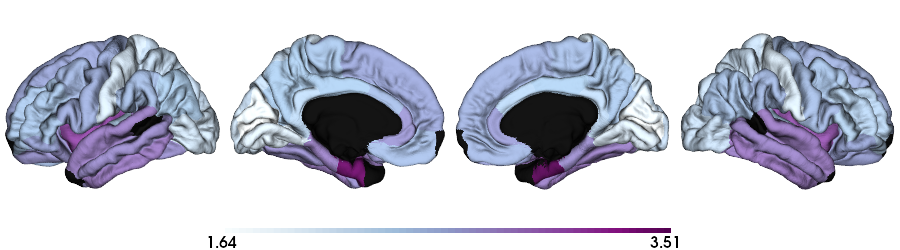

In [67]:
# plot labels on surface
print("plotting CT values")
plot_array = CT_df["mean_CT"].values
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='BuPu', transparent_bg=True, color_bar='bottom', layout_style="compact",)